# Lab 2: Flexure of the oceanic lithosphere under island chains 

In this lab, we will solve the plate flexure equation for an ocean island load numerically using finite-differences. We will compare the model results to read data from Hawai'i and estimate the effective elastic thickness of the Pacific plate underneath the islands.

Learning objectives:

* Build on the theorical knowledge acquired in [Lecture 2](https://www.leouieda.com/envs398/slides/2-isostasy/).
* Learn how to apply the finite-difference method to solve partial differential equations.
* Gain a practical understanding of plate flexure.


## General instructions

This is a [Jupyter notebook](https://jupyter.org/) running in [Jupyter Lab](https://jupyterlab.readthedocs.io/en/stable/). The notebook is a programming environment that mixes code (the parts with `[1]: ` or similar next to them) and formatted text/images/equations with [Markdown](https://www.markdownguide.org/basic-syntax) (like this part right here).

Quick start guide:

* **Edit** any cell (blocks of code or text) by double clicking on it.
* **Execute** a code or Markdown cell by typing `Shift + Enter` after selecting it.
* The current active cell is the one with a **blue bar next to it**.
* You can run cells **in any order** as long as the code sequence makes sense (it's best to go top-to-bottom, though).
* To copy any file to the current directory, drag and drop it to the file browser on the left side.
* Notebook files have the extension `.ipynb`.

## The plate flexure equation

The equation describing the deflection ($w$) of an elastic plate subject to a vertical load is:

$ D\dfrac{\partial^4 w}{\partial x^4} = q(x) - (\rho_m - \rho_w) g w $

in which $w$ is the deflection (how much the plate bends up or down), $x$ is the position, $D$ is the flexural rigidity of the plate, $rho_c$ and $rho_m$ are the crust and mantle densities, $g$ is gravity (for these purposes, assume $9.8\ m/s^2$), and $q(x)$ is a force density applied by the load on the plate (the weight of the topography). The term $(\rho_m - \rho_w) g w$ is the restoring hydrostatic force (buoyancy) from replacing mantle material at depth with water on top because of the deflection.

One of the the assumptions we're taking here is that the lithosphere has a density $\rho_m$ same as the underlying mantle. So we're effectively disregarding the crustal part of the lithosphere. 

The flexural rigidity can be described in terms of the plate's elastic parameters:

$D = \dfrac{E T_e^3}{12(1 - \nu^2)}$

$E$ is [Young's modulus](https://en.wikipedia.org/wiki/Young's_modulus), $\nu$ is [Poisson's ratio](https://en.wikipedia.org/wiki/Poisson's_ratio), and $T_e$ is the *effective elastic thickness* (the reference books use $h$ for this but $T_e$ is very common in the literature).

The **load force per unit area** $q(x)$ is the weight of the load applied on the lithosphere. For a load of height $h$ and density $\rho_c$, the weight per unit area is (negative because the force is applied downwards):

$q(x) = -g \rho_c h(x)$

**Note:** For a detailed derivation of these equations and analytical solutions, see "Chapter 3: Elasticity and Flexure" of "Geodynamics" by Turcotte and Schubert.

## Boundary conditions

We need to consider the appropriate boundary conditions for the loading of the oceanic lithosphere by an island chain. If we assume that the load is applied at the middle of the plate, we can consider the boundaries as stable lithosphere under no load. In that case, we don't expect to see any deflection at the boundaries:

$w(x=0) = 0$ and $w(x=x_{max}) = 0$

We also need to imposed conditions on the derivative of $w$. If there is no deflection, we can also assume that the first derivative of deflection is zero (the plate approaches the boundaries horizontally, not at an angle):

$\dfrac{\partial w}{\partial x}(x=0) = 0$ and $\dfrac{\partial w}{\partial x}(x=x_{max}) = 0$

## Finite-difference solution

The finite-difference method is a way of calculating an approximate solution to partial differential equations. Numerical solutions allows us to solve problems for complex sources and mediums for which analytical solutions might not have been found.

Remembering our calculus, the derivative is defined as:

$\dfrac{\partial w}{\partial x}(x) = \lim_{\Delta x \to 0} \dfrac{w(x + \Delta x) - w(x)}{\Delta x}$

The main concept for finite-differences is approximating the derivative by eliminating the limit above and assuming that $\Delta x$ is sufficiently small:

$\dfrac{\partial w}{\partial x}(x) \approx \dfrac{w(x + \Delta x) - w(x)}{\Delta x}$

The numerical process involves discretizing the continuous value $w(x)$ into evenly spaced points $w_0, w_1, \ldots, w_{N-1}$ with $\Delta x$ spacing between them. In that case, the first derivative between points $w_0$ and $w_1$ can be approximated by:

$\dfrac{\partial w}{\partial x}(x_0) \approx \dfrac{w_1 - w_0}{\Delta x}$

Propagating this to other higher order derivatives: 

![Finite-differences for up to fourth order derivatives.](figures/finite-differences-grid.svg)

With finite-differences, we can calculate the derivative at $x_2$ from values of $w$ in the 5 points around $x_2$.

Using this formulation, the flexure equation in finite-differences form is:

$ 
D \dfrac{w_{i+2} - 4w_{i+1} + 6w_i - 4w_{i-1} + w_{i-2}}{\Delta x^4} = q_i - (\rho_m - \rho_w) g w_i
$

Here, we're using $w_i$ to represent the deflection at an arbitrary node in the grid. Notice that we have discretized the load $q(x)$ at the same locations as well to get $q_i$.

The **boundary conditions** also need to be converted to discrete finite-differences:

$w_0 = 0$ and $w_{N-1} = 0$

$\dfrac{w_1- w_0}{\Delta x} = 0$ and $\dfrac{w_{N-1} - w_{N-2}}{\Delta x} = 0$.

## Solving for $w$

**The deflection $w$ is what we want to calculate so they are the unknowns in this equation.** So we can re-arange the equation above to isolate the $w$ on the left-hand side of the equation and any term not containing $w$ on the other. Also eliminate the division to make our lives easier. 

$ 
D w_{i+2} - 4 D w_{i+1} + \left[6D + \Delta x^4 (\rho_m - \rho_w) g\right] w_i - 4 D w_{i-1} + D w_{i-2} = \Delta x^4 q_i
$

Since we have values of $w$ for multiple values of $i$, we can form an equation system (with the boundary conditions as well):

$
\begin{align*}
  D w_{4} - 4 D w_{3} + \left[6D + \Delta x^4 (\rho_m - \rho_w) g\right] w_2 - 4 D w_{1} + D w_{0} &= \Delta x^4 q_2  \\ 
  D w_{5} - 4 D w_{4} + \left[6D + \Delta x^4 (\rho_m - \rho_w) g\right] w_3 - 4 D w_{2} + D w_{1} &= \Delta x^4 q_3  \\ 
  \vdots & \\
  D w_{i+4} - 4 D w_{i+3} + \left[6D + \Delta x^4 (\rho_m - \rho_w) g\right] w_{i+2} - 4 D w_{i+1} + D w_{i} &= \Delta x^4 q_{i+2}  \\ 
  \vdots & \\
  D w_{N-1} - 4 D w_{N-2} + \left[6D + \Delta x^4 (\rho_m - \rho_w) g\right] w_{N-3} - 4 D w_{N-4} + D w_{N-5} &= \Delta x^4 q_{N-3} \\
  w_0 &= 0  \\
  w_{N-1} &= 0  \\
  w_1 - w_0 &= 0  \\
  w_{N-1} - w_{N-2} &= 0 
\end{align*}
$

With this system, we have $N$ unknowns and $N$ equations ($N-4$ for the flexure equation and $4$ for the boundary conditions). **Solving the system will give us the flexure ($w$) for a given load $q$.**

Another way of writing this equation system is using a matrix notation:

$
\begin{bmatrix}
  a & b & c \\
  d & e & f \\
  g & h & i
 \end{bmatrix}
$

## Import things

As before, the first thing to do is load the Python libraries that we'll be using. We'll group all our imports here at the top to make it easier to see what we're using.

In [2]:
# The base of the entire scientific Python stack
import numpy as np
# For making plots and figures
import matplotlib.pyplot as plt
# To load and operate on data tables
import pandas as pd

## Setup a simplified model first

In [74]:
number_of_nodes = 500
profile_length = 2500 # km
x = np.linspace(0, profile_length, number_of_nodes)
delta_x = x[1] - x[0]

load_height = 5 # km
load_density = 2.8e12 # kg/km³
gravity = 9.8e-3 # km/s²
load = np.zeros_like(x)
load[number_of_nodes // 2] = -gravity * load_density * load_height

density_contrast = 3300e9 - 1040e9 # kg/km³
effective_elastic_thickness = 30 # km
young_modulus = 70e12  # kg/(s²km)
poisson_modulus = 0.25  # dimensionless
flexural_rigidity = young_modulus * effective_elastic_thickness**3 / (12 * (1 - poisson_modulus**2))  # kg.km²/s²

In [76]:
right_hand_side = np.zeros(number_of_nodes)
A = np.zeros((number_of_nodes, number_of_nodes))

for i in range(0, number_of_nodes - 4):
    right_hand_side[i] = delta_x**4 * load[i + 2]
    A[i, i] = flexural_rigidity
    A[i, i + 1] = -4*flexural_rigidity
    A[i, i + 2] = 6*flexural_rigidity + delta_x**4 * density_contrast * gravity
    A[i, i + 3] = -4*flexural_rigidity
    A[i, i + 4] = flexural_rigidity
    
A[-4, 0] = 1
A[-3, -1] = 1
A[-2, 0] = -1
A[-2, 1] = 1
A[-1, -2] = -1
A[-1, -1] = 1

In [77]:
deflection = np.linalg.solve(A, right_hand_side)

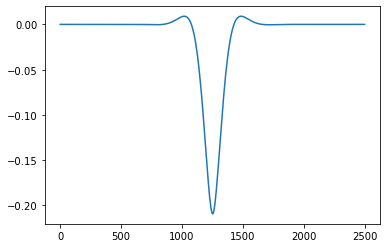

In [79]:
plt.plot(x, deflection)

## Questions

Discuss the following in small groups:
